# Optimal Strategy of plant antiherbivore defence
This is a numerical implementation of the model discussed in Yamamura and Tsuji 1995. 

## Imports

In [151]:
import numpy as np
import matplotlib.pyplot as plt

## Pontryagin's Maximum Principle

### Define constants

In [195]:
A = 3.5
E = 0.06
G = 0.209
h = (lambda x: E*np.exp(-A*x))
g = (lambda C: G*C)

C0 = 3
D0 = 0
x = (lambda C, D: D / (C + D))

T = 20
delta = 0.0001
N = 100
t = np.linspace(0, T, N+1)
# time step
m = T/N

### Setup for numerical solver

In [201]:
u_ = np.zeros(N+1)# + 0.001

C_ = np.zeros(N+1) + 0.0001 # To prevent errors with x
C_[0] = C0
D_ = np.zeros(N+1) + 0.0001
D_[0] = D0

lambdaC_ = np.zeros(N+1)  + 20
lambdaD_ = np.zeros(N+1) + 20

### Numerical Solver

In [202]:
test = -1
while test < 0:
    #print(test)
    oldu_ = u_
    oldC_ = C_
    oldD_ = D_
    oldlambdaC_ = lambdaC_
    oldlambdaD_ = lambdaD_
    
    # Forward solving of 'x'
    for i in range(N):
        # k# are approximations for dC/dt and l# are for dD/dt
        k1 = (1 - u_[i]) * g(C_[i]) - h(x(C_[i], D_[i])) * C_[i]
        l1 = u_[i] * g(C_[i]) - h(x(C_[i], D_[i])) * D_[i]
        
        k2 = (1 - 0.5 * (u_[i] + u_[i+1])) * g(C_[i] + 0.5*k1*m) - h(x(C_[i] + 0.5*k1*m, D_[i] + 0.5*l1*m)) * (C_[i] + 0.5*k1*m)
        l2 = (0.5 * (u_[i] + u_[i+1])) * g(C_[i] + 0.5*k1*m) - h(x(C_[i] + 0.5*k1*m, D_[i] + 0.5*l1*m)) * (D_[i] + 0.5*l1*m)
        
        k3 = (1 - 0.5*(u_[i] + u_[i+1]))*g(C_[i] + 0.5*k2*m) - h(x(C_[i] + 0.5*k2*m, D_[i] + 0.5*l2*m)) * (C_[i] + 0.5*k2*m)
        l3 = (0.5*(u_[i] + u_[i+1]))*g(C_[i] + 0.5*k2*m) - h(x(C_[i] + 0.5*k2*m, D_[i] + 0.5*l2*m)) * (D_[i] + 0.5*l2*m)

        k4 = (1 - u_[i+1]) * g(C_[i] + k3*m) - h(x(C_[i] + k3*m, D_[i] + l3*m)) * (C_[i] + k3*m)
        l4 = u_[i+1] * g(C_[i] + k3*m) - h(x(C_[i] + k3*m, D_[i] + l3*m)) * (D_[i] + l3*m)
        
        C_[i+1] = C_[i] + (m/6)*(k1 + 2*k2 + 2*k3 + k4)
        D_[i+1] = D_[i] + (m/6)*(l1 + 2*l2 + 2*l3 + l4)
        #print(D_[i+1])
    
    lambdaC_[N] = 1
    lambdaD_[N] = 0
    
    # Backward solving of 'lambda'
    for j in range(N, 0, -1):
        # k# are approximations for d/dt(lambdaC) and l# are for d/dt(lambdaD)
        x1 = x(C_[j], D_[j])
        k1 = -G*((1 - u_[j])*lambdaC_[j] + u_[j]*lambdaD_[j]) + \
             (A*x1*(1-x1) + 1)*E*np.exp(-A*x1)*lambdaC_[j] + \
             A*E*(x1**2)*np.exp(-A*x1)*lambdaD_[j]
        l1 = -A*E*((1-x1)**2)*np.exp(-A*x1)*lambdaC_[j] + \
             (-A*x1*(1-x1) + 1)*E*np.exp(-A*x1)*lambdaD_[j]
        
        x2 = x(0.5*(C_[j] + C_[j-1]), 0.5*(D_[j] + D_[j-1]))
        k2 = -G*((1 - 0.5*(u_[j]+u_[j-1]))*(lambdaC_[j] - 0.5*k1*m) + 0.5*(u_[j]+u_[j-1])*(lambdaD_[j] - 0.5*l1*m)) + \
             (A*x2*(1-x2) + 1)*E*np.exp(-A*x2)*(lambdaC_[j] - 0.5*k1*m) + \
             A*E*(x2**2)*np.exp(-A*x2)*(lambdaD_[j] - 0.5*l1*m)
        l2 = -A*E*((1-x2)**2)*np.exp(-A*x2)*(lambdaC_[j] - 0.5*k1*m) + \
             (-A*x2*(1-x2) + 1)*E*np.exp(-A*x2)*(lambdaD_[j] - 0.5*l1*m)
        
        k3 = -G*((1 - 0.5*(u_[j]+u_[j-1]))*(lambdaC_[j] - 0.5*k2*m) + 0.5*(u_[j]+u_[j-1])*(lambdaD_[j] - 0.5*l2*m)) + \
             (A*x2*(1-x2) + 1)*E*np.exp(-A*x2)*(lambdaC_[j] - 0.5*k2*m) + \
             A*E*(x2**2)*np.exp(-A*x2)*(lambdaD_[j] - 0.5*l2*m)
        l3 = -A*E*((1-x2)**2)*np.exp(-A*x2)*(lambdaC_[j] - 0.5*k2*m) + \
             (-A*x2*(1-x2) + 1)*E*np.exp(-A*x2)*(lambdaD_[j] - 0.5*l2*m)
        
        x4 = x(C_[j-1], D_[j-1])
        k4 = -G*((1 - u_[j-1])*(lambdaC_[j] - k3*m) + u_[j-1]*(lambdaD_[j] - l3*m)) + \
             (A*x4*(1-x4) + 1)*E*np.exp(-A*x4)*(lambdaC_[j] - k3*m) + \
             A*E*(x4**2)*np.exp(-A*x4)*(lambdaD_[j] -l3*m)
        l4 = -A*E*((1-x4)**2)*np.exp(-A*x4)*(lambdaC_[j] - k3*m) + \
             (-A*x4*(1-x4) + 1)*E*np.exp(-A*x4)*(lambdaD_[j] - l3*m)
        
        lambdaC_[j-1] = lambdaC_[j] - (m/6)*(k1 + 2*k2 + 2*k3 + k4)
        lambdaD_[j-1] = lambdaD_[j] - (m/6)*(l1 + 2*l2 + 2*l3 + l4)
    """
    dlambdaC_ = np.concatenate(((lambdaC_[1:] - lambdaC_[:-1]) / m, [(lambdaC_[-1] - lambdaC_[-2])/m]))
    #print(dD)
    x_ = x(C_,D_)
    temp = (dlambdaC_ - (A*x_*(1-x_) + 1)*E*np.exp(-A*x_)*lambdaC_ - A*E*(x_**2)*np.exp(-A*x_)*lambdaD_) / (-G*(lambdaD_-lambdaC_)) \
           - lambdaC_ / (lambdaD_ - lambdaC_)
    u1 = np.minimum(1, np.maximum(temp, 0))
    u_ = 0.5*(u1 + oldu_)
    """
    temp1 = delta*np.sum(np.abs(u_)) - np.sum(np.abs(oldu_ - u_))
    temp2 = delta*np.sum(np.abs(C_)) - np.sum(np.abs(oldC_ - C_))
    temp3 = delta*np.sum(np.abs(D_)) - np.sum(np.abs(oldD_ - D_))
    temp4 = delta*np.sum(np.abs(lambdaC_)) - np.sum(np.abs(oldlambdaC_ - lambdaC_))
    temp5 = delta*np.sum(np.abs(lambdaD_)) - np.sum(np.abs(oldlambdaD_ - lambdaD_))
    test = min(temp1, temp2, temp3, temp4, temp5)

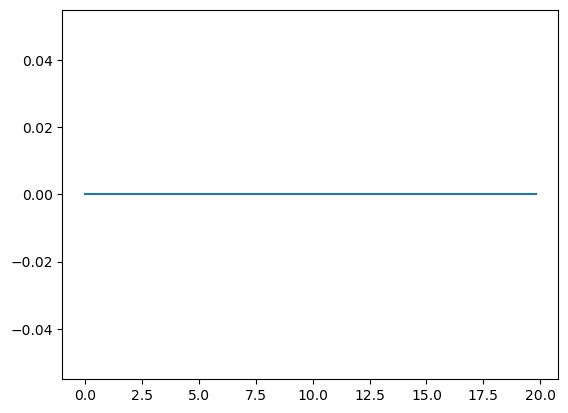

In [203]:
plt.plot(t[:-1], u_[:-1])

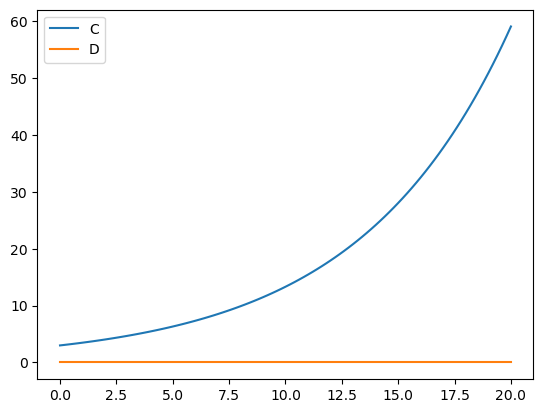

In [204]:
plt.plot(t, C_, label='C')
plt.plot(t, D_, label='D')
plt.legend()
plt.show()

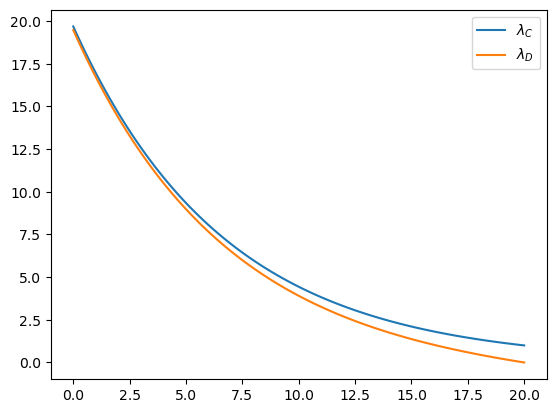

In [205]:
plt.plot(t, lambdaC_, label=r'$\lambda_C$')
plt.plot(t, lambdaD_, label=r'$\lambda_D$')
plt.legend()
plt.show()

## Modified Yamamura
I have altered the hamiltonian to explicitly consider dC/dt as an optimization criterion. I hypothesize that this will lead to greater values of C under the same conditions compared to what was reported into the paper (in other words, the authors were incorrectly maximizing for C).

In [178]:
test = -1
while test < 0:
    #print(test)
    oldu_ = u_
    oldC_ = C_
    oldD_ = D_
    oldlambdaC_ = lambdaC_
    oldlambdaD_ = lambdaD_
    
    # Forward solving of 'x'
    for i in range(N):
        # k# are approximations for dC/dt and l# are for dD/dt
        k1 = (1 - u_[i]) * g(C_[i]) - h(x(C_[i], D_[i])) * C_[i]
        l1 = u_[i] * g(C_[i]) - h(x(C_[i], D_[i])) * D_[i]
        
        k2 = (1 - 0.5 * (u_[i] + u_[i+1])) * g(C_[i] + 0.5*k1*m) - h(x(C_[i] + 0.5*k1*m, D_[i] + 0.5*l1*m)) * (C_[i] + 0.5*k1*m)
        l2 = (0.5 * (u_[i] + u_[i+1])) * g(C_[i] + 0.5*k1*m) - h(x(C_[i] + 0.5*k1*m, D_[i] + 0.5*l1*m)) * (D_[i] + 0.5*l1*m)
        
        k3 = (1 - 0.5*(u_[i] + u_[i+1]))*g(C_[i] + 0.5*k2*m) - h(x(C_[i] + 0.5*k2*m, D_[i] + 0.5*l2*m)) * (C_[i] + 0.5*k2*m)
        l3 = (0.5*(u_[i] + u_[i+1]))*g(C_[i] + 0.5*k2*m) - h(x(C_[i] + 0.5*k2*m, D_[i] + 0.5*l2*m)) * (D_[i] + 0.5*l2*m)

        k4 = (1 - u_[i+1]) * g(C_[i] + k3*m) - h(x(C_[i] + k3*m, D_[i] + l3*m)) * (C_[i] + k3*m)
        l4 = u_[i+1] * g(C_[i] + k3*m) - h(x(C_[i] + k3*m, D_[i] + l3*m)) * (D_[i] + l3*m)
        
        C_[i+1] = C_[i] + (m/6)*(k1 + 2*k2 + 2*k3 + k4)
        D_[i+1] = D_[i] + (m/6)*(l1 + 2*l2 + 2*l3 + l4)
        #print(D_[i+1])
    
    lambdaC_[N] = 1
    lambdaD_[N] = 0
    
    # Backward solving of 'lambda'
    for j in range(N, 0, -1):
        # k# are approximations for d/dt(lambdaC) and l# are for d/dt(lambdaD)
        x1 = x(C_[j], D_[j])
        k1 = -G*((1 - u_[j])*lambdaC_[j] + u_[j]*lambdaD_[j]) \
             + (A*x1*(1-x1) + 1)*E*np.exp(-A*x1)*lambdaC_[j] \
             + A*E*(x1**2)*np.exp(-A*x1)*lambdaD_[j] \
             + E*np.exp(-A*x1)*(1 + A*x1*(1-x1))
        l1 = -A*E*((1-x1)**2)*np.exp(-A*x1)*lambdaC_[j] \
             + (-A*x1*(1-x1) + 1)*E*np.exp(-A*x1)*lambdaD_[j] \
             + E*A*np.exp(-A*x1)*(1-x1)**2
        
        x2 = x(0.5*(C_[j] + C_[j-1]), 0.5*(D_[j] + D_[j-1]))
        k2 = -G*((1 - 0.5*(u_[j]+u_[j-1]))*(lambdaC_[j] - 0.5*k1*m) + 0.5*(u_[j]+u_[j-1])*(lambdaD_[j] - 0.5*l1*m)) \
             + (A*x2*(1-x2) + 1)*E*np.exp(-A*x2)*(lambdaC_[j] - 0.5*k1*m) \
             + A*E*(x2**2)*np.exp(-A*x2)*(lambdaD_[j] - 0.5*l1*m) \
             + E*np.exp(-A*x2)*(1 + A*x2*(1-x2))
        l2 = -A*E*((1-x2)**2)*np.exp(-A*x2)*(lambdaC_[j] - 0.5*k1*m) \
             + (-A*x2*(1-x2) + 1)*E*np.exp(-A*x2)*(lambdaD_[j] - 0.5*l1*m) \
             + E*A*np.exp(-A*x2)*(1-x2)**2
        
        k3 = -G*((1 - 0.5*(u_[j]+u_[j-1]))*(lambdaC_[j] - 0.5*k2*m) + 0.5*(u_[j]+u_[j-1])*(lambdaD_[j] - 0.5*l2*m)) \
             + (A*x2*(1-x2) + 1)*E*np.exp(-A*x2)*(lambdaC_[j] - 0.5*k2*m) \
             + A*E*(x2**2)*np.exp(-A*x2)*(lambdaD_[j] - 0.5*l2*m) \
             + E*np.exp(-A*x2)*(1 + A*x2*(1-x2))
        l3 = -A*E*((1-x2)**2)*np.exp(-A*x2)*(lambdaC_[j] - 0.5*k2*m) \
             + (-A*x2*(1-x2) + 1)*E*np.exp(-A*x2)*(lambdaD_[j] - 0.5*l2*m) \
             + E*A*np.exp(-A*x2)*(1-x2)**2
        
        x4 = x(C_[j-1], D_[j-1])
        k4 = -G*((1 - u_[j-1])*(lambdaC_[j] - k3*m) + u_[j-1]*(lambdaD_[j] - l3*m)) \
             + (A*x4*(1-x4) + 1)*E*np.exp(-A*x4)*(lambdaC_[j] - k3*m) \
             + A*E*(x4**2)*np.exp(-A*x4)*(lambdaD_[j] -l3*m) \
             + E*np.exp(-A*x4)*(1 + A*x4*(1-x4))
        l4 = -A*E*((1-x4)**2)*np.exp(-A*x4)*(lambdaC_[j] - k3*m) \
             + (-A*x4*(1-x4) + 1)*E*np.exp(-A*x4)*(lambdaD_[j] - l3*m) \
             + E*A*np.exp(-A*x2)*(1-x2)**2
        
        lambdaC_[j-1] = lambdaC_[j] - (m/6)*(k1 + 2*k2 + 2*k3 + k4)
        lambdaD_[j-1] = lambdaD_[j] - (m/6)*(l1 + 2*l2 + 2*l3 + l4)
    """
    dlambdaC_ = np.concatenate(((lambdaC_[1:] - lambdaC_[:-1]) / m, [(lambdaC_[-1] - lambdaC_[-2])/m]))
    #print(dD)
    x_ = x(C_,D_)
    temp = (dlambdaC_ - (A*x_*(1-x_) + 1)*E*np.exp(-A*x_)*lambdaC_ - A*E*(x_**2)*np.exp(-A*x_)*lambdaD_) / (-G*(lambdaD_-lambdaC_)) \
           - lambdaC_ / (lambdaD_ - lambdaC_)
    u1 = np.minimum(1, np.maximum(temp, 0))
    u_ = 0.5*(u1 + oldu_)
    """
    temp1 = delta*np.sum(np.abs(u_)) - np.sum(np.abs(oldu_ - u_))
    temp2 = delta*np.sum(np.abs(C_)) - np.sum(np.abs(oldC_ - C_))
    temp3 = delta*np.sum(np.abs(D_)) - np.sum(np.abs(oldD_ - D_))
    temp4 = delta*np.sum(np.abs(lambdaC_)) - np.sum(np.abs(oldlambdaC_ - lambdaC_))
    temp5 = delta*np.sum(np.abs(lambdaD_)) - np.sum(np.abs(oldlambdaD_ - lambdaD_))
    test = min(temp1, temp2, temp3, temp4, temp5)

array([20.        ,  0.77377898,  0.7731262 ,  0.77274762,  0.77262481,
        0.77273994,  0.77307593,  0.77361643,  0.77434593,  0.77524973,
        0.77631398,  0.77752563,  0.77887248,  0.78034309,  0.7819268 ,
        0.78361368,  0.7853945 ,  0.78726069,  0.78920433,  0.79121806,
        0.79329512,  0.79542924,  0.79761466,  0.79984609,  0.80211865,
        0.8044279 ,  0.80676974,  0.80914046,  0.81153668,  0.81395533,
        0.81639365,  0.81884915,  0.82131962,  0.82380307,  0.82629779,
        0.82880223,  0.83131508,  0.83383518,  0.83636156,  0.83889337,
        0.8414299 ,  0.84397054,  0.84651478,  0.84906218,  0.85161236,
        0.85416502,  0.85671989,  0.85927672,  0.86183533,  0.86439555,
        0.86695724,  0.8695203 ,  0.87208464,  0.87465021,  0.87721698,
        0.87978495,  0.88235415,  0.88492461,  0.88749643,  0.89006968,
        0.89264449,  0.895221  ,  0.89779936,  0.90037976,  0.90296238,
        0.90554744,  0.90813515,  0.91072577,  0.91331954,  0.91

## Hamilton-Jacobi-Bellman PDE / Dynamic Programming

In [72]:
m = 0.2
psi = (lambda x: 0*x)
x0 = 0.4
xmin = 0
xmax = 0.5
umin = 0
umax = 1
xnum = 300
unum = 1000
big_num = 10**10
g = (lambda x, t, u: -(m+u)*x)
f = (lambda x, t, y: A*k*(t/(t+1))*x*u - u**2)
h = (xmax - xmin) / (xnum-1)
xx = np.linspace(xmin, xmax, xnum)

tau = h / ((m+umax)*xmax)
tnum = int(np.ceil(T / tau) + 1)
tau = T / (tnum - 1)
tt = np.linspace(0, T, tnum)

uu = np.linspace(umin, umax, unum)

V = -big_num*np.ones((tnum, xnum))
U = (umin - 1) * np.ones((tnum, xnum))
V[tnum-1, :] = psi(xx)

In [73]:
for n in range(tnum-2, 0, -1):
    t = tt[n]
    V_future = V[n+1, :]
    V_future_left = np.concatenate(([big_num], V[n+1, :-1]))
    V_future_right = np.concatenate((V[n+1, 1:], [big_num]))
    BestVal = -np.inf * np.ones(xx.size)
    BestU = (umin-1) * np.ones(xx.size)
    
    for u in uu:
        ff = f(xx, t, u)
        gg = g(xx, t, u)
        shift = tau * gg
        assert(np.sum(np.abs(shift) <= h) == xnum)
        dir_left = (shift < 0)
        dir_right = 1-dir_left
        assert(shift[0] >= 0)
        assert(shift[-1] <= 0)
        
        c_other = np.abs(shift)/h
        c_this = 1 - c_other
        Val = dir_left * (c_other * V_future_left + c_this * V_future) \
            + dir_right * (c_other * V_future_right + c_this * V_future) \
            + tau * ff
        
        new_best = (Val > BestVal)
        BestVal[new_best] = Val[new_best]
        BestU[new_best] = u
    
    V[n, :] = BestVal
    U[n, :] = BestU

In [74]:
V

array([[-1.00000000e+10, -1.00000000e+10, -1.00000000e+10, ...,
        -1.00000000e+10, -1.00000000e+10, -1.00000000e+10],
       [ 0.00000000e+00,  3.30071503e-03,  8.74132735e-03, ...,
         8.38049525e+00,  8.41284144e+00,  8.44519702e+00],
       [ 0.00000000e+00,  3.30255592e-03,  8.74739741e-03, ...,
         8.38585190e+00,  8.41821770e+00,  8.45059288e+00],
       ...,
       [ 0.00000000e+00,  8.04808172e-06,  3.21844251e-05, ...,
         1.20048173e-01,  1.20471143e-01,  1.20894114e-01],
       [ 0.00000000e+00,  4.02547833e-06,  1.61019133e-05, ...,
         6.01300967e-02,  6.03419390e-02,  6.05537813e-02],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

In [75]:
x_current = x0
x_traj = [x_current]
u_traj = []
Optimal_Value = 0
for n in range(1, tnum):
    t = tt[n]
    
    left_neighb = int(np.floor((x_current - xmin) / h) + 1)
    assert(left_neighb > 0)
    right_neighb = int(left_neighb + 1)
    assert(right_neighb <= xnum)
    
    c_right = (x_current - ( (left_neighb -1)*h + xmin)) / h
    assert(c_right <= 1 and c_right >= 0)
    c_left = 1 - c_right
    u = c_left * U[n, left_neighb] + c_right*U[n, right_neighb]
    
    Optimal_Value = Optimal_Value + tau*f(x_current, t, u)
    x_current = x_current + tau*g(x_current, t, u)
    x_traj.append(x_current)
    u_traj.append(u)

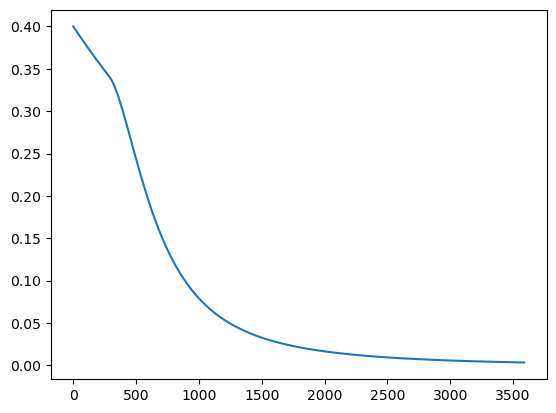

In [76]:
plt.plot(x_traj)

In [79]:
x_traj[-1]

0.003315512161300843

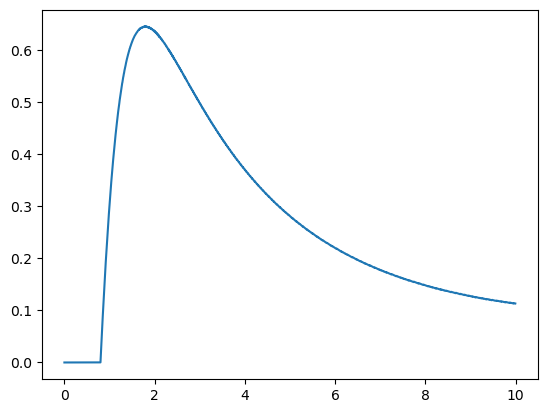

In [77]:
plt.plot(tt[:-2], u_traj[:-1])

In [78]:
u_traj[-2]

0.11335314893275932